In [1]:
#Loading in necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

In [2]:
#Loading in datasets

sentiment = pd.read_csv("/work/news_sentiment_data.csv")
sentiment = sentiment[["date", "News Sentiment"]]
sentiment["date"] = pd.to_datetime(sentiment["date"])
cpi = pd.read_csv("/work/CPIAUCSL.csv")
cpi["DATE"] = pd.to_datetime(cpi["DATE"])

In [3]:
#Getting sentiment data from Jan. 2000 to June 10, 2023

sentiment = sentiment[7286:].reset_index().drop("index", axis=1)
sentiment["Month"] = sentiment['date'].dt.month
sentiment["Year"] = sentiment["date"].dt.year
sentiment["Day"] = sentiment["date"].dt.day
sentiment

,date,News Sentiment,Month,Year,Day
0,2000-01-01,0.28,1,2000,1
1,2000-01-02,0.30,1,2000,2
2,2000-01-03,0.31,1,2000,3
3,2000-01-04,0.29,1,2000,4
4,2000-01-05,0.31,1,2000,5
...,...,...,...,...,...
8558,2023-06-07,-0.38,6,2023,7
8559,2023-06-08,-0.38,6,2023,8
8560,2023-06-09,-0.39,6,2023,9
8561,2023-06-10,-0.37,6,2023,10


In [8]:
m_sent = sentiment.groupby(["Month", "Year"])["News Sentiment"].mean().reset_index()
m_sent = m_sent.sort_values(["Year", "Month"]).reset_index().drop("index", axis=1)
m_sent

,Month,Year,News Sentiment
0,1,2000,0.310323
1,2,2000,0.268966
2,3,2000,0.247742
3,4,2000,0.205333
4,5,2000,0.221613
...,...,...,...
277,2,2023,-0.039286
278,3,2023,-0.130323
279,4,2023,-0.218333
280,5,2023,-0.344194


In [9]:
cpi = cpi[1:].reset_index().drop("index", axis=1)
cpi.head()

,DATE,CPIAUCSL
0,2000-01-01,169.3
1,2000-02-01,170.0
2,2000-03-01,171.0
3,2000-04-01,170.9
4,2000-05-01,171.2


Text(0.5, 1.0, 'Daily Economic Sentiment from Jan 2000 to June 2023')

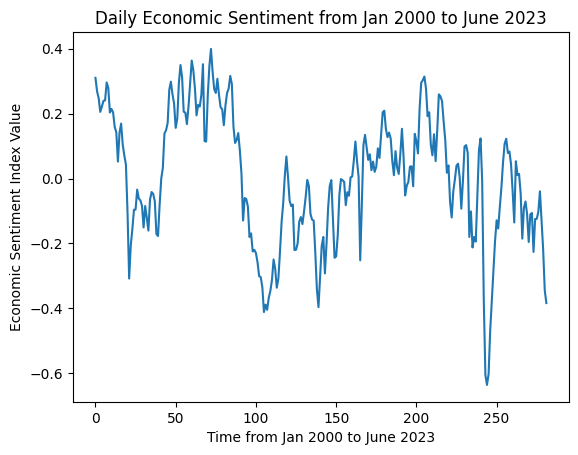

In [ ]:
#Initial plotting of economic sentiment data

plt.plot(m_sent["News Sentiment"])
plt.xlabel("Time from Jan 2000 to June 2023")
plt.ylabel("Economic Sentiment Index Value")
plt.title("Daily Economic Sentiment from Jan 2000 to June 2023")

In [ ]:
#Creating an adfuller test function to use on data --> helps us see if it's stationary or not

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

In [ ]:
#Not stationary

adfuller(m_sent["News Sentiment"])

(-2.470357192265759,
 0.1228543178373292,
 13,
 268,
 {'1%': -3.454988209954765,
  '5%': -2.8723857312734613,
  '10%': -2.572549407997327},
 -628.0093584903661)

Text(0.5, 1.0, 'Change in Economic Sentiment from Feb 2000 to June 2023')

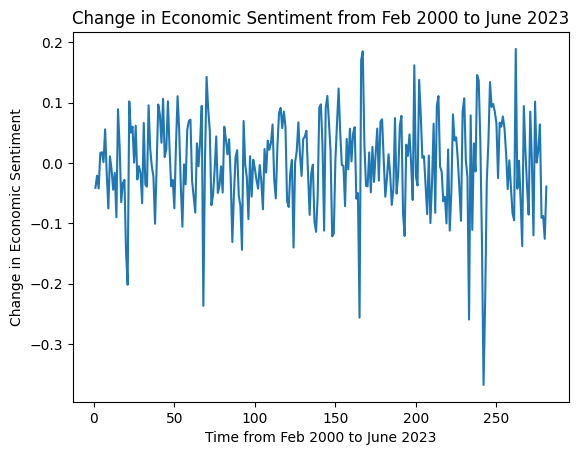

In [ ]:
#Can use changes in sentiment, which will give us a stationary time series

percent_diffs = [m_sent["News Sentiment"].diff()[1:][i]/m_sent["News Sentiment"][i-1] for i in range(1, len(m_sent["News Sentiment"].diff()[1:]))]
plt.plot(m_sent["News Sentiment"].diff()[1:])
plt.xlabel("Time from Feb 2000 to June 2023")
plt.ylabel("Change in Economic Sentiment")
plt.title("Change in Economic Sentiment from Feb 2000 to June 2023")

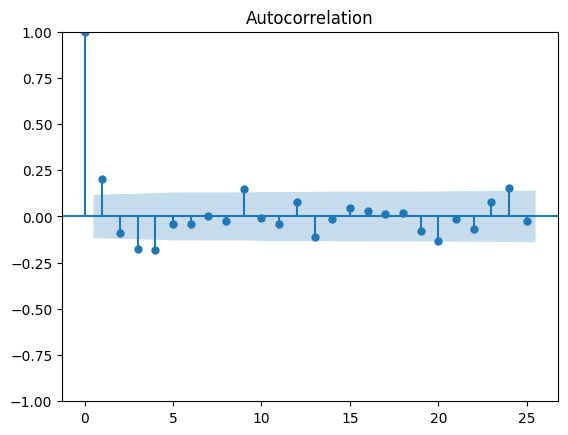

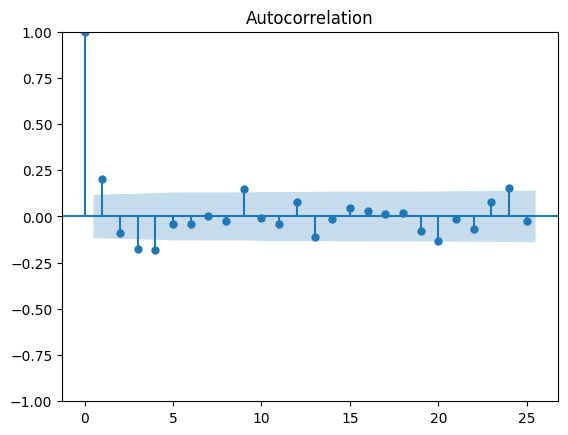

In [ ]:
plot_acf(m_sent["News Sentiment"].diff()[1:])

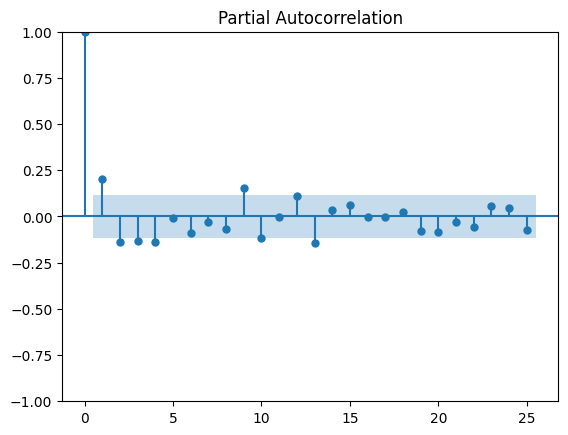

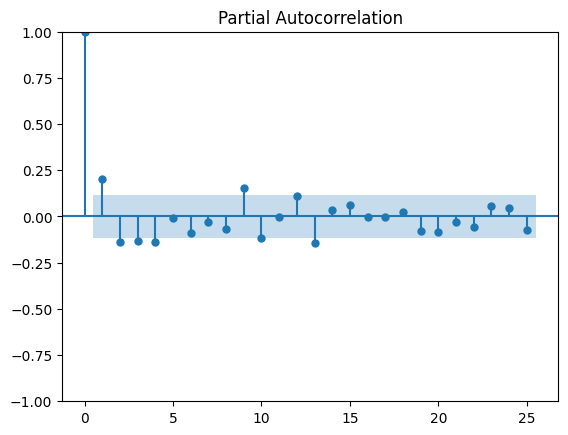

In [ ]:
plot_pacf(m_sent["News Sentiment"].diff()[1:])

Text(0, 0.5, 'Index Value')

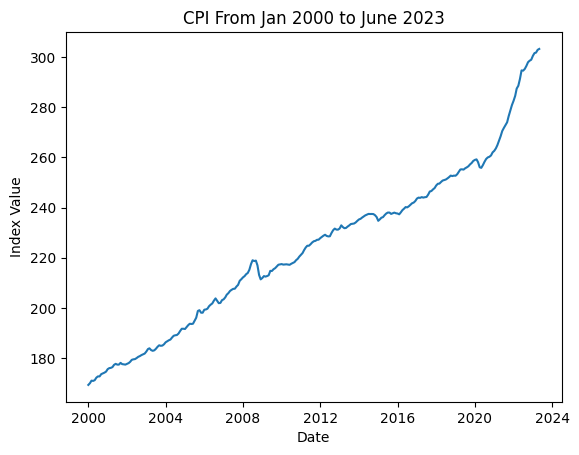

In [ ]:
#Plotting CPI --> definitely not stationary

plt.plot(cpi["DATE"], cpi["CPIAUCSL"])
plt.title("CPI From Jan 2000 to June 2023")
plt.xlabel("Date")
plt.ylabel("Index Value")

Text(0, 0.5, 'MoM Inflation Rate')

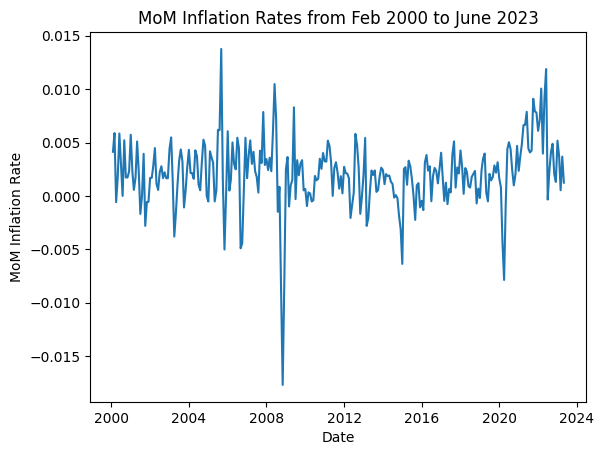

In [ ]:
#Making a statioanry series

cpi_percent_diffs = [cpi["CPIAUCSL"].diff()[1:][i]/cpi["CPIAUCSL"][i-1] for i in range(1, len(cpi))]

plt.plot(cpi["DATE"][1:], cpi_percent_diffs)
plt.title("MoM Inflation Rates from Feb 2000 to June 2023")
plt.xlabel("Date")
plt.ylabel("MoM Inflation Rate")

In [ ]:
adfuller(cpi_percent_diffs)

(-3.005318943633423,
 0.03440065468419956,
 14,
 265,
 {'1%': -3.4552699038400827,
  '5%': -2.8725092359464526,
  '10%': -2.5726152830188678},
 -2359.962872922439)

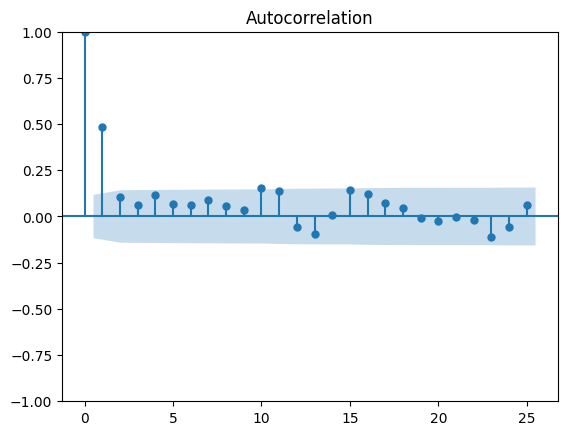

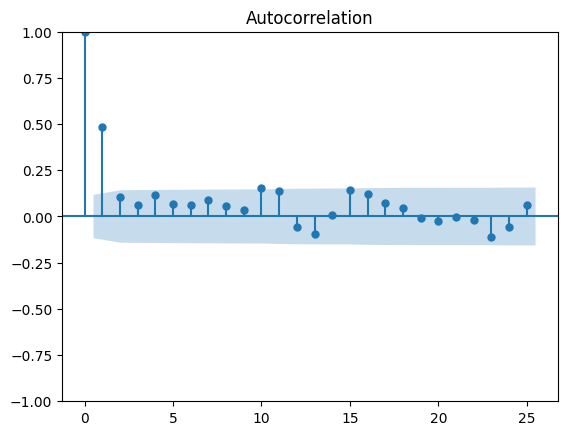

In [ ]:
plot_acf(np.array(cpi_percent_diffs))

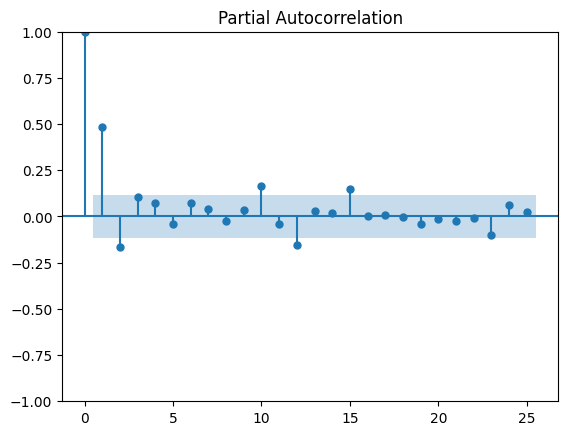

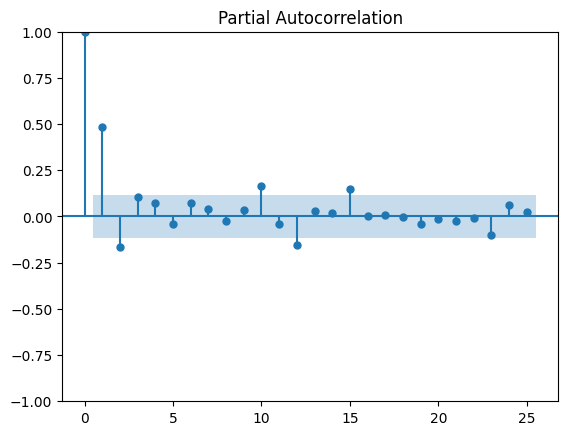

In [ ]:
plot_pacf(np.array(cpi_percent_diffs))

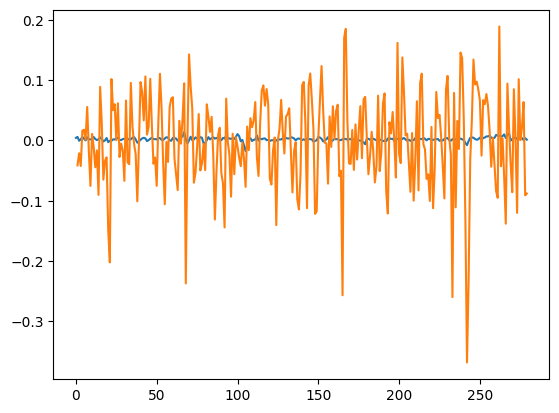

In [ ]:
plt.plot(cpi_percent_diffs)
plt.plot(m_sent["News Sentiment"].diff()[1:280])

In [ ]:
#Fitting a VAR model to the data to see predictive value of sentiment

analysis_df = pd.DataFrame(data={"Sentiment":m_sent["News Sentiment"].diff()[1:281], "Inflation":cpi_percent_diffs})
model = VAR(analysis_df)
model_fit = model.fit(maxlags=5)
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Jun, 2023
Time:                     02:11:19
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -16.6988
Nobs:                     275.000    HQIC:                  -16.8720
Log likelihood:           1577.45    FPE:                4.18985e-08
AIC:                     -16.9881    Det(Omega_mle):     3.87375e-08
--------------------------------------------------------------------
Results for equation Sentiment
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                0.003022         0.006583            0.459           0.646
L1.Sentiment         0.185428         0.061768            3.002           0.003
L1.Inflation        -0.034818         1.732420           -0.

In [ ]:
#Prediction of June CPI change --> roughly +0.2%

june_pred = 0.001012 + 0.006798*m_sent["News Sentiment"].diff()[1:][280] + 0.572408*cpi_percent_diffs[-2] + -0.173562*cpi_percent_diffs[-3]
june_pred

0.002169563706042084

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=da60976f-6168-484c-8854-860fb673f453' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>